In [1]:
from killmap import Killmap
from patch import load_changes
from collections import defaultdict
import os
import d4j
import gzip
import xml.sax as sax

def _parse_tarbz_level(name):
    elems = name.split("-")
    size = len(elems)
    if size == 3:
        return elems[-1].split(".")[0]
    elif size == 4:
        return "_".join([elems[2], elems[3].split(".")[0]])

    raise Exception()
    

class PitParser(sax.handler.ContentHandler):


    def __init__(self, test_size, method_changes, line_changes):
        self._method_name = None
        self._class_name = None
        self.killmap = {}
        self.mutants = {}
        self.method_mutants = set()
        self._freeze = False
        self.stmt_mutants = set()
        self._mutator = None
        self._index = None
        self._block = None
        self._test_size = test_size
        self._content = ""
        self._warn = set()
        self._method_changes = method_changes
        self._line_changes = line_changes

    def endDocument(self):
        super().endDocument()
        killmap = self.killmap
        for i in range(self._test_size - len(killmap)):
            killmap[str(i)] = []

    def endElement(self, name):
        content = self._content
        self._content = ""
        if name == "mutatedClass":
            self._class_name = content
        elif name == "mutatedMethod":
            self._method_name = content
        elif name == "methodDescription":
            self._method_desc = _parse_desc(content)
        elif name == "lineNumber":
            self._line = int(content)
        elif name == "mutator":
            self._mutator = content
        elif name == "index":
            self._index = int(content)
        elif name == "block":
            self._block = int(content)
        elif name == "killingTests":
            idx = len(self.mutants)
            for name in content.split("|"):
                if len(name) == 0:
                    continue

                x = self.killmap.get(name)
                if x is None:
                    x = set()
                    self.killmap[name] = x

                x.add(idx)
        elif name == "mutation":
            mutant_key = (self._class_name, self._method_name, self._line, self._mutator, self._block, self._index,)
            idx = self.mutants.get(mutant_key)
            if idx is None:
                idx = len(self.mutants)
                self.mutants[mutant_key] = idx

                total_name = self._class_name + "@" + self._method_name + self._method_desc
                if total_name in self._method_changes:
                    self.method_mutants.add(idx)

                if self._line in self._line_changes[self._class_name]:
                    self.stmt_mutants.add(idx)

    def characters(self, content):
        self._content += content
        
        
type_map = {
    "I": "int",
    "J": "long",
    "S": "short",
    "B": "byte",
    "C": "char",
    "F": "float",
    "D": "double",
    "Z": "boolean",
    "V": "void"
}
def _parse_desc(change):
    global type_map
    suffix = ""
    params = []

    idx = 1
    while idx < len(change):
        c = change[idx]
        idx += 1
        if c == ")":
            break
        elif c == "[":
            suffix = "[]"
        elif c == "L":
            end = change.find(";", idx)
            type_name = change[idx:end].replace("/", ".")
            params.append(type_name + suffix)
            suffix = ""
            idx = end + 1
        else:
            t = type_map[c]
            params.append(t + suffix)
            suffix = ""

    return "(" + ",".join(params) + ")"
        
        
def _map_evosuite(tarbz):
    level = "_" + _parse_tarbz_level(tarbz)
    def _assign(name):
        cls_name, method_name = name.split("::")
        return cls_name + level + "_" + method_name

    return _assign


def _load_xml(suite_dir, test_size, method_changes, line_changes):
    parser = PitParser(test_size, method_changes, line_changes)
    count = 0
    for file in os.listdir(suite_dir):
        if not file.endswith(".xml.gz"):
            continue

        with gzip.GzipFile(os.path.join(suite_dir, file), 'rb') as fh:
            sax.parse(fh, parser)

        count += 1

    if count < 2:
        return None


    return parser
        
        
def compute_pit(pit, suite_dir):
    killmap = []
    trigger_tests = []
    fails = set()
    file_list = os.listdir(suite_dir)

    for fail_file in filter(lambda x: x.endswith(".fails"), file_list):
        tarbz = fail_file[:-6]
        if "evosuite" in fail_file:
            mapper = _map_evosuite(tarbz)
        else:
            mapper = lambda n: n

        with open(os.path.join(suite_dir, fail_file), "r", encoding='UTF8') as fh:
            for l in fh:
                l = l.strip()
                if l.startswith("---"):
                    name = l.strip()[4:]
                    try:
                        name = mapper(name)
                    except KeyError:
                        print(tarbz, name)
                        return None

                    fails.add(name)
                    
    if len(fails) == 0:
        return
    
    test_size = 0
    for killmap_file in filter(lambda x: x.endswith(".killmap.csv"), file_list):
        with open(os.path.join(suite_dir, killmap_file)) as fh:
            for line in fh:
                if len(line.strip()) == 0:
                    continue

                test_size += 1

    if test_size < 532:
        return

    pit_result = _load_xml(suite_dir, test_size, method_changes, line_changes)
    if pit_result is None:
        return

    stop = False
    if len(pit_result.stmt_mutants) == 0 or len(pit_result.method_mutants) == 0:
        return

    relevant = set()
    for test_name, indices in pit_result.killmap.items():
        idx = test_name.find("(")
        if idx >= 0:
            test_name = test_name[:idx]

        idx = test_name.rfind(".")
        test_name = test_name[:idx] + "::" + test_name[idx + 1:]
        try:
            fails.remove(test_name)
        except KeyError:
            continue
            
        relevant |= indices

    if len(relevant) == 0:
        return
    
    pit["class"].append(len(relevant))
    pit["cls_total"].append(len(pit_result.mutants))
    pit["method"].append(len(pit_result.method_mutants & relevant))
    pit["method_total"].append(len(pit_result.method_mutants))
    pit["stmt"].append(len(pit_result.stmt_mutants & relevant))
    pit["stmt_total"].append(len(pit_result.stmt_mutants))


def compute_major(major, suite_dir, line_mutants, method_mutants, mutants_size):
    method_mutants = set(method_mutants)
    line_mutants = set(line_mutants)
    fails = set()
    file_list = os.listdir(suite_dir)
    for fail_file in filter(lambda x: x.endswith(".fails"), file_list):
        with open(os.path.join(suite_dir, fail_file), "r", encoding="utf8") as fh:
            for l in fh:
                l = l.strip()
                if l.startswith("---"):
                    name = l.strip()[4:]
                    fails.add(name)

    if len(fails) == 0:
        return
    
    relevant = set()
    has_one = False
    count = 0
    for killmap_file in filter(lambda x: x.endswith(".killmap.csv"), file_list):
        with open(os.path.join(suite_dir, killmap_file)) as fh:
            for line in fh:
                row = line.strip().split(",")
                count += 1

                try:
                    fails.remove(row[0])
                except KeyError:
                    continue

                has_one = True
                for idx in range(1, len(row)):
                    if row[idx] in {"EXC", "FAIL"}:
                        relevant.add(idx - 1)
                        
    if count < 532 or not has_one:
        return

    major["class"].append(len(relevant))
    major["cls_total"].append(mutants_size)
    major["method"].append(len(method_mutants & relevant))
    major["method_total"].append(len(method_mutants))
    major["stmt"].append(len(line_mutants & relevant))
    major["stmt_total"].append(len(line_mutants))

major = {
    "class": [],
    "cls_total": [],
    "method": [],
    "method_total": [],
    "stmt": [],
    "stmt_total": []
}

pit = {
    "class": [],
    "cls_total": [],
    "method": [],
    "method_total": [],
    "stmt": [],
    "stmt_total": []
}

for proj_name in d4j.NAMES:
    for bug_id, line_changes, method_changes, line_mutants, method_mutants, count in d4j.iterate_instance(proj_name):
        suite_dir = os.path.join("suites", proj_name, bug_id + "f")
        compute_major(major, suite_dir, line_mutants, method_mutants, count)
        compute_pit(pit, suite_dir)

Time: Total 26 instances
Time: 0 no fine-level mutants
Closure: Total 174 instances
Closure: 0 no fine-level mutants
Lang: Total 64 instances
Lang: 0 no fine-level mutants
Math: Total 106 instances
Math: 0 no fine-level mutants
Chart: Total 26 instances
Chart: 0 no fine-level mutants


In [3]:
import pandas as pd

m = pd.DataFrame(major)
m["class"] = m.apply(lambda r: r["class"] / r["cls_total"], axis=1)
m["method"] = m.apply(lambda r: r["method"] / r["method_total"], axis=1)
m["stmt"] = m.apply(lambda r: r["stmt"] / r["stmt_total"], axis=1)
m.median()

class             0.152284
cls_total       451.000000
method            0.395349
method_total     45.000000
stmt              0.562500
stmt_total        9.000000
dtype: float64

In [4]:
m = pd.DataFrame(pit)
m["class"] = m.apply(lambda r: r["class"] / r["cls_total"], axis=1)
m["method"] = m.apply(lambda r: r["method"] / r["method_total"], axis=1)
m["stmt"] = m.apply(lambda r: r["stmt"] / r["stmt_total"], axis=1)
m.median()

class             0.173913
cls_total       218.000000
method            0.480000
method_total     21.000000
stmt              0.750000
stmt_total        4.000000
dtype: float64

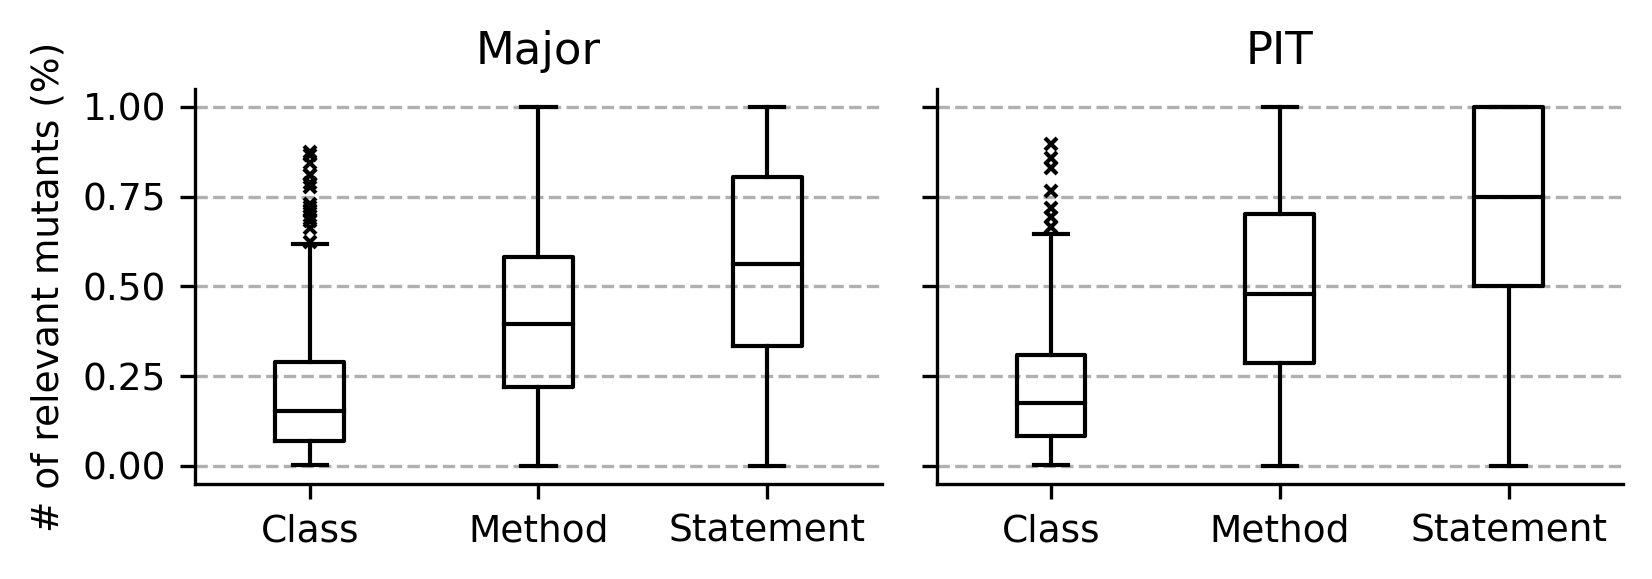

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import util
import matplotlib
font = {'size'   : 9}
matplotlib.rc('font', **font)

fig, axes = plt.subplots(1, 2, figsize=(5.5, 2,), dpi=300, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
names = ["Major", "PIT"]
for idx, data in enumerate([major, pit]):
    df = pd.DataFrame(data)
    df["class"] = df.apply(lambda r: r["class"] / r["cls_total"], axis=1)
    df["method"] = df.apply(lambda r: r["method"] / r["method_total"], axis=1)
    df["stmt"] = df.apply(lambda r: r["stmt"] / r["stmt_total"], axis=1)

    
    axs = axes[idx]
    df = df.loc[:, ["class", "method", "stmt"]]
    df.columns = ["Class", "Method", "Statement"]
    flierprops = {'marker': 'x', 'markersize': 3}
    boxprops = dict(linestyle='-', linewidth=1)
    colorprops=dict(boxes='black', whiskers='black', caps='black')
    df.boxplot(showfliers=True, ax = axs, flierprops=util.flierprops, medianprops=util.medianprops, boxprops=util.boxprops, color=util.colorprops)

    if idx == 0:
        axs.set_ylabel("# of relevant mutants (%)")

    axs.set_title(names[idx])
    axs.get_xaxis().grid(False)
    axs.get_yaxis().grid(True, linestyle='--')
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
#     axs.get_xaxis().set_visible(False)
    axs.get_yaxis().grid(True, linestyle='--')
plt.tight_layout()
plt.savefig('../seke/fig8.png', format='png', dpi=300, bbox_inches='tight')